In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import RFR
import uncertainty_rfr

---

## Loading data in to perform the uncertainty calculation
There are separate files for each of the targets being predicted. There are 8 targets total, which makes 8 sets of training and predicting sets of data.

#### DFT data points (training data)
- These data sets contain the descriptors and targets for the training data. There are ~1300 points in the formation energy sets (a, b) and ~750 points in the transition level sets (p32-m23). 
- The descriptors in each set are different, and were selected through expanding an original set of features and then using LASSO to select those most highly correlated with outputs.

In [2]:
a_dft = pd.read_csv('./xiaofeng_lasso/DFT_y_12k_X/Lasso_HA_dft_12k.csv')

In [3]:
b_dft = pd.read_csv('./xiaofeng_lasso/DFT_y_12k_X/Lasso_HB_dft_12k.csv')

In [4]:
p32_dft = pd.read_csv('./xiaofeng_lasso/DFT_y_12k_X/Lasso_(+3,+2)_dft_12k.csv')

In [5]:
p21_dft = pd.read_csv('./xiaofeng_lasso/DFT_y_12k_X/Lasso_(+2,+1)_dft_12k.csv')

In [6]:
p01_dft = pd.read_csv('./xiaofeng_lasso/DFT_y_12k_X/Lasso_(+1,0)_dft_12k.csv')

In [7]:
m01_dft = pd.read_csv('./xiaofeng_lasso/DFT_y_12k_X/Lasso_(0,-1)_dft_12k.csv')

In [8]:
m12_dft = pd.read_csv('./xiaofeng_lasso/DFT_y_12k_X/Lasso_(-1,-2)_dft_12k.csv')

In [9]:
m23_dft = pd.read_csv('./xiaofeng_lasso/DFT_y_12k_X/Lasso_(-2,-3)_dft_12k.csv')

The formation energy training sets are:
- ~80 % II-VI semicondcutors
- ~11 % IV-IV semicondcutors
- ~9 % III-V semiconductors

There is approximately equal distribution of the defect site among all the data points

In [10]:
RFR.counter(a_dft, 'Type')

Total entries:  1269


,Type,percent
II-VI,1014,79.91
IV-IV,145,11.43
III-V,110,8.67


In [11]:
RFR.counter(a_dft, 'Site')

Total entries:  1269


,Site,percent
M_i_neut,267,21.04
M_i_A,264,20.80
M_A,257,20.25
M_i_B,253,19.94
M_B,228,17.97


The formation energy sets are:
- ~63 % II-VI semicondcutors
- ~21 % IV-IV semicondcutors
- ~16 % III-V semiconductors

There is approximately equal distribution of the defect site among all the data points

In [12]:
RFR.counter(p32_dft, 'Type')

Total entries:  748


,Type,percent
II-VI,471,62.97
IV-IV,160,21.39
III-V,117,15.64


In [13]:
RFR.counter(p32_dft, 'Site')

Total entries:  748


,Site,percent
M_A,161,21.52
M_i_A,159,21.26
M_i_neut,154,20.59
M_i_B,143,19.12
M_B,131,17.51


#### Full chemical space data points (predicting data)
- These data sets contain the descriptors for ~12,500 points of data. Each data point is a unique semiconductor/impurity dopant/dopant site combination.
- Each target value being predicted (2 formation energy values, 6 transition energy values) have a different set of descriptors, the same descriptors as the corresponding training datasets above.

In [14]:
a_12k = pd.read_csv('./xiaofeng_lasso/full_chemspace/HA_fullchem_6.16.csv')

In [15]:
b_12k = pd.read_csv('./xiaofeng_lasso/full_chemspace/HB_fullchem_6.16.csv')

In [16]:
p32_12k = pd.read_csv('./xiaofeng_lasso/full_chemspace/(+3,+2)_fullchem_6.16.csv')

In [17]:
p21_12k = pd.read_csv('./xiaofeng_lasso/full_chemspace/(+2,+1)_fullchem_6.16.csv')

In [18]:
p01_12k = pd.read_csv('./xiaofeng_lasso/full_chemspace/(+1,0)_fullchem_6.16.csv')

In [19]:
m01_12k = pd.read_csv('./xiaofeng_lasso/full_chemspace/(0,-1)_fullchem_6.16.csv')

In [20]:
m12_12k = pd.read_csv('./xiaofeng_lasso/full_chemspace/(-1,-2)_fullchem_6.16.csv')

In [21]:
m23_12k = pd.read_csv('./xiaofeng_lasso/full_chemspace/(-2,-3)_fullchem_6.16.csv')

The full chemical space predicting sets are:
- ~25 % II-VI semicondcutors
- ~26 % IV-IV semicondcutors
- ~49 % III-V semiconductors

There is approximately equal distribution of the defect site among all the data points

In [22]:
RFR.counter(a_12k, 'Type')

Total entries:  12474


,Type,percent
III-V,6160,49.38
IV-IV,3234,25.93
II-VI,3080,24.69


In [23]:
RFR.counter(a_12k, 'Site')

Total entries:  12474


,Site,percent
M_A,2618,20.99
M_i_neut,2618,20.99
M_i_A,2618,20.99
M_i_B,2310,18.52
M_B,2310,18.52


-----

A sample data set ~(0.1% of the size of the original data set), to perform a sample calculation

In [24]:
sample_a_12k = a_12k.sample(frac=0.001)
#sample_a_12k

## Prediction and uncertainty calculation (through cross validation)

I am runnning a prediction calculation with cross validation using the function ``uncertainty_rfr_cv``. The function takes in a data set to train the model, here it is ``a_dft``, and then another data set to predict on, here it is ``sample_a_12k``. In each fold of a 5-fold of cross validation, ~80% of the DFT data is used to train the model which will then predict on the full chemical space points. This is repeated n-folds times to make n-folds predictions for every point point in full chemical space data set. The mean and standard deviation across these 5 predictions is returned in a table. On the actual full 12,500 points, this calculation can take ~2 hrs, so I have added a timer thanks to tqdm that updates a progress bar to let you know where the progress is!

In [25]:
dHA_sample, uncertdf_dHA_sample = \
    uncertainty_rfr.uncertainty_rfr_cv(a_dft, sample_a_12k, Y='none', o = 0, d_start=5, x_start=4, true_y=False,
                                        num_trees=300, max_depth=10, max_feat='auto', min_samp_leaf=11, min_samples_split=6)

This is the table that the function returns. This is just a fraction of the size of the actual data set returned from this calculation if it is performed on the full chemical space. If the points being predicted on had actual (or DFT) values associated with them, the column 'true val' would have values. Because the full chemical space points do not have values associated with them, the column is just 0 values.

In [26]:
uncertdf_dHA_sample.drop(['true val'], axis=1)

,Type,AB,Site,Impurity,mean,std
index,,,,,,
7245,III-V,GaAs,M_i_neut,Ca,2.923963,0.060011
4030,III-V,BAs,M_i_A,S,5.808407,0.444007
6935,III-V,GaAs,M_A,Be,2.652174,0.144376
1611,II-VI,ZnO,M_A,Dy,1.957564,0.071284
1605,II-VI,ZnO,M_A,Nd,1.975039,0.071741
8654,III-V,InAs,M_i_A,Cl,4.311744,0.124126
10224,IV-IV,SiC,M_A,Pt,2.979475,0.308714
1627,II-VI,ZnO,M_B,B,3.752713,0.146211
11181,IV-IV,SnC,M_i_B,Si,4.868275,0.332018


-------
---------
# Plotting the uncertainties
Below, we can load in the predicted value data sets and evaluate the uncertainty from training across folds of the cross validation. Predictions using a machine learning model are never absolute measurements, there is uncertainty in the prediction. Here, we have leveraged the difference in training data to determine uncertainty in the models predictions.

### Loading in uncertainty datasets that I made with the function above

In [27]:
uncert_a = pd.read_csv('./uncertainty/CV_uncertainty/6.16_200619/uncertCV12_6p16_HA.csv')

In [28]:
uncert_b = pd.read_csv('./uncertainty/CV_uncertainty/6.16_200619/uncertCV12_6p16_HB.csv')

In [29]:
uncert_p32 = pd.read_csv('./uncertainty/CV_uncertainty/6.16_200619/uncertCV12_6p16_(+3,+2).csv')

In [30]:
uncert_p21 = pd.read_csv('./uncertainty/CV_uncertainty/6.16_200619/uncertCV12_6p16_(+2,+1).csv')

In [31]:
uncert_0p1 = pd.read_csv('./uncertainty/CV_uncertainty/6.16_200619/uncertCV12_6p16_(+1,0).csv')

In [32]:
uncert_0m1 = pd.read_csv('./uncertainty/CV_uncertainty/6.16_200619/uncertCV12_6p16_(0,-1).csv')

In [33]:
uncert_m12 = pd.read_csv('./uncertainty/CV_uncertainty/6.16_200619/uncertCV12_6p16_(-1,-2).csv')

In [34]:
uncert_m23 = pd.read_csv('./uncertainty/CV_uncertainty/6.16_200619/uncertCV12_6p16_(-2,-3).csv')

Function to visualize and evaluate the standard deviation in predicitons, per output

In [35]:
def fullchem_describe(df, col='std', plt_title='dHA'):
    '''
    This function makes a dataframe of the mean, std dev, median, min and max
    of a column of data from a dataframe, and also plots a hist of the points
    in that column. 
    
    Inputs
        - df: pandas df. From the uncertainty_rfr_cv function above.
        - col: str. column from df to calc the mean, std dev, median,
        min and max. Default: std
        - plt_title: str. Title for the plot, and for the x-axis. Default: dHA
    Outputs
        - descrip: pd df. mean, std dev, min, median, max of a column of data.
    '''
    count = pd.DataFrame(data= df[col].describe())
    descrip = count.T.drop(['count', '25%', '75%'], axis=1)
    descrip.insert(0, 'output', plt_title)
    descrip.set_index('output', inplace=True)
    
    plt.hist(df[col], bins=300)
    plt.title(plt_title, fontsize=18)
    plt.xlabel('Std dev of predicted {} (eV)'.format(plt_title), fontsize=14)
    plt.show()
    
    return descrip

In [36]:
def minmax_range(df, col):
    '''
    Finds the range of values in a column of data
    Inputs
        - df: pandas df. From the uncertainty_rfr_cv function above.
        - col: str. column from df to caculate range on
    Outputs
        - delta: float. range value of the column.
    '''
    delta = df[col].max()-df[col].min()
    
    return round(delta,3)

----
For each output, the range of predicted values is first calculated to get a sense of the values for the energy predictions could be (this in eV). Then, uncertainty (determined by the standard deviation of the values across the folds of cross validation) is plotted and a table of the mean, standard devviation, minimum, median, and maximum of the cross validation standard deviation values is displayed.

### ∆H (A-rich)	

In [37]:
minmax_range(uncert_a, 'mean')

6.396

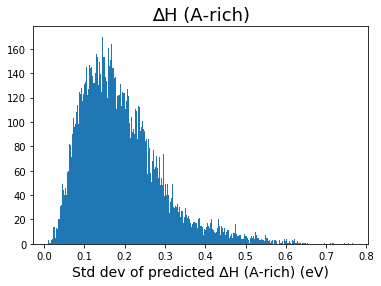

,mean,std,min,50%,max
output,,,,,
∆H (A-rich),0.191737,0.101286,0.010452,0.172821,0.766347


In [38]:
a_sd_plot = fullchem_describe(uncert_a, 'std', '∆H (A-rich)')
a_sd_plot

### ∆H (B-rich)	

In [39]:
minmax_range(uncert_b, 'mean')

8.584

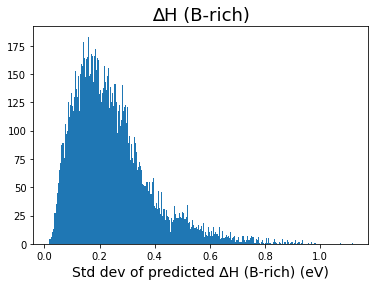

,mean,std,min,50%,max
output,,,,,
∆H (B-rich),0.244152,0.143338,0.015137,0.216274,1.118624


In [54]:
b_sd_plot = fullchem_describe(uncert_b, 'std', '∆H (B-rich)')
b_sd_plot

### (+3/+2)

In [41]:
minmax_range(uncert_p32, 'mean')

1.778

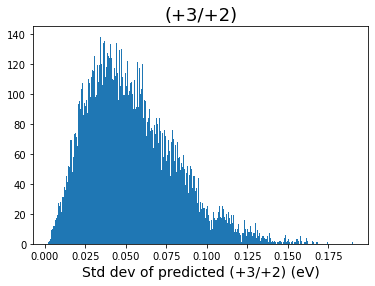

,mean,std,min,50%,max
output,,,,,
(+3/+2),0.05378,0.027507,0.002269,0.049573,0.190024


In [42]:
p32_sd_plot = fullchem_describe(uncert_p32, 'std', '(+3/+2)')
p32_sd_plot

### (+2/+1)

In [43]:
minmax_range(uncert_p21, 'mean')

1.679

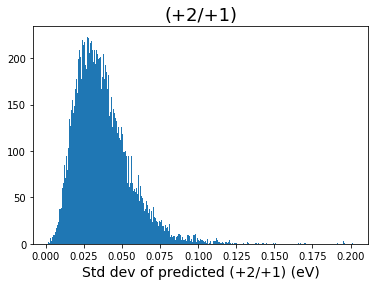

,mean,std,min,50%,max
output,,,,,
(+2/+1),0.037406,0.018502,0.0018,0.034336,0.201429


In [44]:
p21_sd_plot = fullchem_describe(uncert_p21, 'std', '(+2/+1)')
p21_sd_plot

### (+1/0)

In [45]:
minmax_range(uncert_0p1, 'mean')

2.158

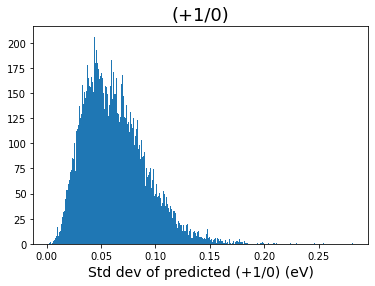

,mean,std,min,50%,max
output,,,,,
(+1/0),0.062867,0.029311,0.001726,0.058986,0.281389


In [46]:
p01_sd_plot = fullchem_describe(uncert_0p1, 'std', '(+1/0)')
p01_sd_plot

### (0/-1)

In [47]:
minmax_range(uncert_0m1, 'mean')

2.641

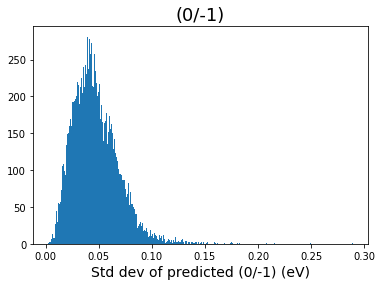

,mean,std,min,50%,max
output,,,,,
(0/-1),0.046796,0.021664,0.002539,0.043814,0.28933


In [48]:
m01_sd_plot = fullchem_describe(uncert_0m1, 'std', '(0/-1)')
m01_sd_plot

### (-1/-2)

In [49]:
minmax_range(uncert_m12, 'mean')

3.275

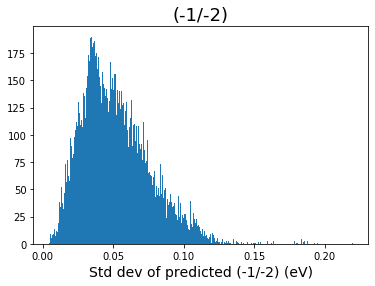

,mean,std,min,50%,max
output,,,,,
(-1/-2),0.051797,0.024461,0.004093,0.048222,0.220061


In [50]:
m12_sd_plot = fullchem_describe(uncert_m12, 'std', '(-1/-2)')
m12_sd_plot

### (-2/-3)

In [51]:
minmax_range(uncert_m23, 'mean')

3.662

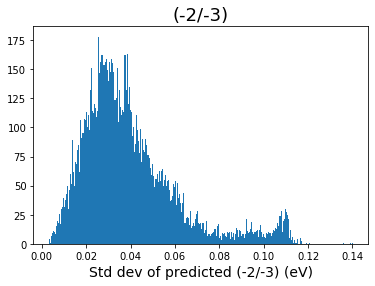

,mean,std,min,50%,max
output,,,,,
(-2/-3),0.039814,0.021945,0.003067,0.034897,0.140192


In [52]:
m23_sd_plot = fullchem_describe(uncert_m23, 'std', '(-2/-3)')
m23_sd_plot

Comparing all the results shows that the output values that span a larger range, the formation energies, are predicted with higher uncertainty. But, relatively speaking, the differences in predictions between folds of the cross validation are relatively low.

In [55]:
concat = pd.concat([a_sd_plot, b_sd_plot, p32_sd_plot,
           p21_sd_plot, p01_sd_plot, m01_sd_plot,
           m12_sd_plot, m23_sd_plot])
concat

,mean,std,min,50%,max
output,,,,,
∆H (A-rich),0.191737,0.101286,0.010452,0.172821,0.766347
∆H (B-rich),0.244152,0.143338,0.015137,0.216274,1.118624
(+3/+2),0.053780,0.027507,0.002269,0.049573,0.190024
(+2/+1),0.037406,0.018502,0.001800,0.034336,0.201429
(+1/0),0.062867,0.029311,0.001726,0.058986,0.281389
(0/-1),0.046796,0.021664,0.002539,0.043814,0.289330
(-1/-2),0.051797,0.024461,0.004093,0.048222,0.220061
(-2/-3),0.039814,0.021945,0.003067,0.034897,0.140192


------
### Quantile Regression Forests
There are other ways to evaluate uncertainty in Random Forest Regression. One way is called quantile regression forest (QRF). In this method, the prediction from every tree in the random forest is recorded (instead of the normal RFR method where a mean of all the trees gives the prediction in the end). Recording everyone of these predictions creates a gaussian distribution of vallues, and similar to this method, the mean and std deviation can be calculated. There is a function ``uncertainty_rfr_qfr`` that performs this calculation. I have found that the QFR method gives a much larger distribution of values. I think this is because some of the trees in the forest do not select good descriptors to make good predictions off of. In normal RFR, these trees would be given less when when the forest is being calculated, but in QFR it is given equal weight as every other point. 